# 聚类分析
## 先层次聚类定类数（层次聚类可视化结果在最后的输出呈现）、再给定类数用kmeans聚类

In [1]:
country=['USA',
 'Brazil',
 'India',
 'Russia',
 ' South Africa',
 'Mexico',
 'Spain',
 'Peru',
 'Colombia',
 'Argentina',
 'Pakistan',
 'Chile',
 'Kazakhstan',
 'UK',
 'France',
 'Belgium',
 'Netherlands',
 'Portugal',
 'Austria',
 'Switzerland',
 'Turkey',
 'Ecuador',
 'Germany',
 'Qatar',
 'China',
 'Ireland',
 'Afghanistan',
 'Italy',
 'South Korea',
 'Egypt',
 'Sweden',
 'Bolivia',
 'United Arab Emirates',
 'Ghana',
 'Guatemala',
 'Philippines',
 'Israel',
 'Iraq',
 'Dominica',
 'Romania',
 'Serbia',
 'Azerbaijan',
 'Algeria',
 'Oman',
 'Japan',
 'Panama',
 'Poland',
 'Moldova',
 'Armenia',
 'Nigeria',
 'Kuwait',
 'Bahrain',
 'Singapore',
 'Ukraine',
 'Iran']

In [2]:
import numpy as np 
import pandas as pd 
from datetime import datetime


covid=pd.read_csv('worldometer_coronavirus_daily_data.csv')
covid_cum=pd.read_csv('worldometer_coronavirus_summary_data.csv')
covid['date'] = pd.to_datetime(covid['date'])

vaccine = pd.read_csv('country_vaccinations.csv')
vaccine_manu = pd.read_csv('country_vaccinations_by_manufacturer.csv')
vaccine['date'] = pd.to_datetime(vaccine['date'])
vaccine_manu['date'] =pd.to_datetime(vaccine_manu['date'])

In [3]:
#空值填充为0
covid_1=covid.fillna(value=0)
covid_cum.columns
#所有的字段

Index(['country', 'continent', 'total_confirmed', 'total_deaths',
       'total_recovered', 'active_cases', 'serious_or_critical',
       'total_cases_per_1m_population', 'total_deaths_per_1m_population',
       'total_tests', 'total_tests_per_1m_population', 'population'],
      dtype='object')

In [4]:
covid_sum=covid_cum[['country','total_confirmed', 'total_deaths','population','active_cases']]
df_vaccine=vaccine[['country', 'date', 'people_fully_vaccinated','daily_vaccinations',"vaccines"]]#筛选后的字段
df_vaccine=df_vaccine.fillna(value=0)

In [5]:
df_vaccine.country = df_vaccine.country.replace().replace({
    "Czechia": "Czech Republic", 
    "United States": "USA", 
    "United Kingdom": "UK", 
    "Isle of Man": "Isle Of Man",
    "Republic of Ireland": "Ireland",
    "Northern Cyprus" : "Cyprus"
})
df_vaccine = df_vaccine[df_vaccine.country.apply(lambda x: x not in ['England', 'Scotland', 'Wales', 'Northern Ireland'])]
#把这个几个属于英国的地区筛选掉
final_covid = pd.merge(covid_1, covid_sum, on=['country'])
final_covid=final_covid.fillna(value=0)
final_covid.rename(columns={'active_cases_x':'active_cases','active_cases_y':'total_active_cases'}, inplace = True) 
#把两个感染相关数据集表合成（可以做疫苗接种前的感染人数分析，和接种后的对比）

In [6]:
final=final_covid[final_covid["country"].isin(country)].copy()

In [7]:
#治愈率
b=final.groupby("country").sum()["daily_new_cases"]#总患病
final["cumulative_total_recovery"]=final['cumulative_total_cases'] - final['active_cases'] - final["cumulative_total_deaths"]
a=final.groupby("country").max()["cumulative_total_recovery"]#总治愈
a["curerate"]=a/b


In [8]:
tr=final.groupby("country").max().reset_index()
peak=tr[["country", "daily_new_cases"]].set_index("country").to_dict()["daily_new_cases"]
peak#各国单日新增确诊病例峰值
final["peak"]=final["country"].apply(lambda x :peak[x])

In [9]:
u=final.groupby("country").apply(lambda x:x[-3:]).reset_index(drop=True).groupby(["country"]).mean()
u["efficiency"]=u["peak"]/u["daily_new_cases"]
#防控效率：xmax/m 还有一个没加的系数
#xmax代表每日新增确诊病例最大值；m代表每日新增确诊病例时间序列最后3d平均值

In [10]:
def drop0(x):
    xx=x.values
    daynum=1
    y=[]
    for i in range(len(xx)):
        if xx[i]==0:
            y.append(0)
        if xx[i]!=0:
            y.append(daynum)
            daynum+=1
    ser=pd.Series(y)
    ser.index=x.index
    return ser
    
final["daynum"]=final.groupby("country")["daily_new_cases"].apply(drop0)
#疫情开始传播的第几天

In [11]:
f=final.groupby("country").apply(lambda x: x.sort_values(by="daily_new_cases",ascending=False))
peakday=f.reset_index(drop=True).groupby(["country"]).apply(lambda x:x[0:1]).droplevel(1)["daynum"]
#疫情开始传播的第几天达到单日新增确诊病例峰值,增长时长（初始值到峰值）

In [12]:
explode=final.drop(final[final['daynum']==0].index)
g=explode.groupby(["country"]).apply(lambda x:x[0:1]).reset_index(drop=True).copy()
g["peakday"]=peakday.values-1
g["uprate"]=(g["peak"]/g["daily_new_cases"])**(1/g["peakday"])-1
#平均增长率
g["efficiency"]=u["efficiency"].values
g["curerate"]=a["curerate"].values

In [13]:
#每日新增确诊病例统计特征
g["daynum"]=explode.groupby("country").count()["date"].apply(lambda x :x-1).values
a=explode.groupby("country").mean().reset_index()
b=a[["country", "daily_new_cases"]].set_index("country").to_dict()["daily_new_cases"]
explode["mean"]=explode["country"].apply(lambda x :b[x])
explode["S"]=(explode["daily_new_cases"]-explode["mean"])**2
g["S"]=explode.groupby("country").sum()["S"].values
g["S"]=(g["S"]/g["daynum"])**0.5
#标准差S是描述时间序列全局结构的统计量，用于描述新增确诊病例时间序列的变化幅度

In [14]:
g=g[['country','peakday', 'uprate','efficiency', 'curerate', 'S']].dropna().copy()
model=g[['peakday', 'uprate','efficiency', 'curerate', 'S']].copy()
model.replace([np.inf, -np.inf], 1000000, inplace=True)
m,n=model.shape
model.index=range(m)
model.columns=range(n)

In [15]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(1e-100, 1))
model = pd.DataFrame(scaler.fit_transform(model))


In [18]:
createMatrix = pd.DataFrame(np.zeros((m,m)))#创建一个空矩阵
df=model.copy()
df.iloc[1,:]
def AffMatrix(arrA, arrB):
    c = 0.5
    a = -(np.sum(np.square(np.array(arrA)-np.array(arrB))))
    b = 2 * (np.square(c))
    w = np.exp(a/b)
    return w

def W_Matrix(m, createMatrix):
    for i in range(m):
        x = df.iloc[i,:].values.tolist()
        for j in range(m):
            y = df.iloc[j,:].values.tolist()
            createMatrix.iloc[i,j] = AffMatrix(x,y) 
            #计算的高斯核函数放入创建的空矩阵中
    createMatrix = createMatrix - np.identity(m) # np.identity()创建单位对角矩阵  //  生成对角线为0的矩阵
    return createMatrix
W=W_Matrix(m, createMatrix)

In [19]:
def draw(data, a, b):
    colorSet = [ "blue", "yellow", "red"]
    for i in range(m):
        x = data.iloc[i,a]
        y = data.iloc[i,b]
        color = colorSet[int(data.iloc[i,-1]) % len(colorSet)]
        plt.scatter(x,y, marker="o", c=color, s=20)
    plt.xlabel("x")
    plt.ylabel("y")

In [20]:
D = pd.DataFrame(np.diag(np.sum(W)))#求D（度）矩阵(对角线)
Dn = np.mat(np.diag(np.power(np.sum(W), -0.5)))#求标准化的拉普拉斯矩阵L
W = np.mat(W)
L = Dn * W * Dn
eigvals, eigvecs = np.linalg.eig(L)#计算L的特征值和特征向量

k = 3#分类成3类
indices = eigvals.argsort()[-k:]
k_max_eigvecs = eigvecs[:,indices]
X = np.linalg.norm(k_max_eigvecs, axis=1)#特征向量单位化
Y = pd.DataFrame(np.zeros((m,k)))
for i in range(m):
    for j in range(k):
        Y.iloc[i,j] = k_max_eigvecs[i,j]/X[i]
from sklearn.cluster import KMeans
NJW = KMeans(n_clusters=k).fit_predict(k_max_eigvecs)
category = pd.concat([model,pd.DataFrame(NJW)], axis=1, ignore_index=True)

In [25]:
g.reset_index(inplace=True, drop=True)
g["category"]=category[5].apply(str)

In [26]:
def c(x):
    x=x.values
    return x
g.groupby("category")["country"].apply(c).values

array([array(['Armenia', 'Austria', 'Azerbaijan', 'Belgium', 'Brazil', 'Chile',
              'Colombia', 'France', 'Germany', 'Ghana', 'Iraq', 'Ireland',
              'Israel', 'Italy', 'Japan', 'Kazakhstan', 'Kuwait', 'Moldova',
              'Netherlands', 'Nigeria', 'Oman', 'Panama', 'Philippines',
              'Poland', 'Portugal', 'Romania', 'Russia', 'Serbia', 'South Korea',
              'Spain', 'Sweden', 'Switzerland', 'Turkey', 'UK', 'Ukraine',
              'United Arab Emirates'], dtype=object)                             ,
       array(['Afghanistan', 'Algeria', 'Argentina', 'Bahrain', 'Bolivia',
              'Egypt', 'India', 'Iran', 'Mexico', 'Peru', 'USA'], dtype=object),
       array(['China', 'Dominica', 'Ecuador', 'Guatemala', 'Pakistan', 'Qatar',
              'Singapore'], dtype=object)                                      ],
      dtype=object)

In [27]:
import matplotlib.pyplot as plt

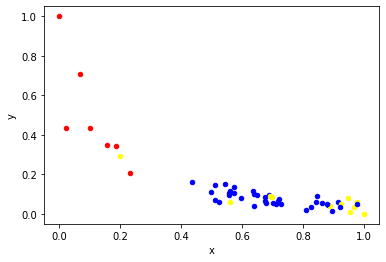

In [28]:
draw(category, 0, 1)

In [30]:
g.replace([np.inf, -np.inf], 1000000, inplace=True)
model[5]=g["category"].values
mean=model.groupby(5).mean()
mean.columns=['peakday', 'uprate', 'efficiency', 'curerate', 'S']
model.columns=[ 'peakday', 'uprate', 'efficiency', 'curerate', 'S', 'category']
data=model.groupby('category').mean().reset_index()

,peakday,uprate,efficiency,curerate,S
category,,,,,
0,319.083333,0.027887,35.248670,0.939562,4291.143562
1,365.636364,0.026838,3.466536,0.821453,16078.463930
2,67.000000,0.115654,167.584618,0.941573,625.064095


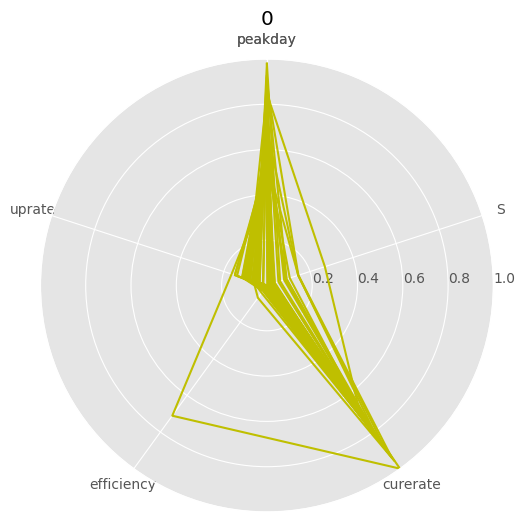

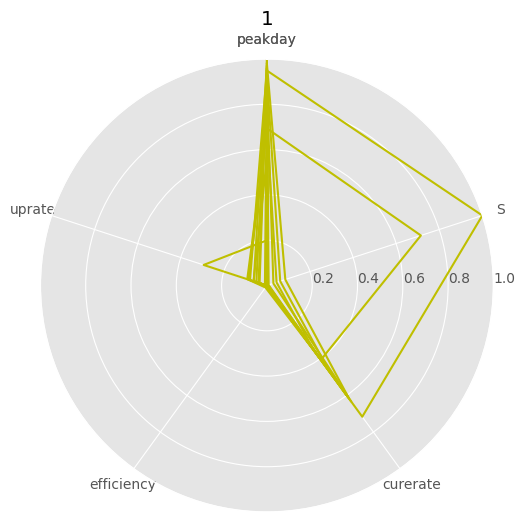

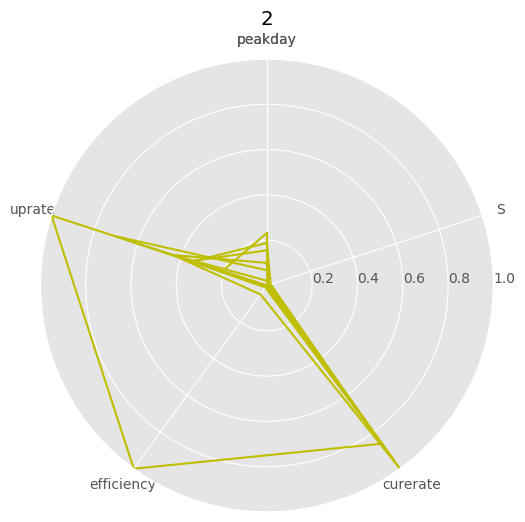

In [36]:
import numpy as np
import matplotlib.pyplot as plt
 
# 使用ggplot的绘图风格，这个类似于美化了，可以通过plt.style.available查看可选值，你会发现其它的风格真的丑。。。
plt.style.use('ggplot')
 
# 构造数据
for j in ["0","1","2"]:
    values = model[model["category"]==j][['peakday', 'uprate', 'efficiency', 'curerate', 'S']].values.tolist()
    key_list = ['peakday', 'uprate', 'efficiency', 'curerate', 'S']

    for i in range(len(values)):
        value_list = values[i]
        values[i] = dict(zip(key_list,value_list))


    results = values

    data_length = len(results[0])

    # 将极坐标根据数据长度进行等分

    angles = np.linspace(0, 2*np.pi, data_length, endpoint=False)

    labels = [key for key in results[0].keys()]

    score = [[v for v in result.values()] for result in results]

    # 使雷达图数据封闭

    score_a = np.concatenate((score[0], [score[0][0]]))

    score_b = np.concatenate((score[1], [score[1][0]]))

    angles = np.concatenate((angles, [angles[0]]))

    labels = np.concatenate((labels, [labels[0]]))

    # 设置图形的大小

    fig = plt.figure(figsize=(8, 6), dpi=100)

    # 新建一个子图

    ax = plt.subplot(111, polar=True)

    # 绘制雷达图
    for i in range(len(results)):
        ax.plot(angles, np.concatenate((score[i], [score[i][0]])), color='y')


    # 设置雷达图中每一项的标签显示

    ax.set_thetagrids(angles*180/np.pi, labels)

    # 设置雷达图的0度起始位置

    ax.set_theta_zero_location('N')

    # 设置雷达图的坐标刻度范围

    ax.set_rlim(0, 1)

    # 设置雷达图的坐标值显示角度，相对于起始角度的偏移量

    ax.set_rlabel_position(270)

    ax.set_title(j)

    plt.show()



In [39]:
model['country']=g["country"].values
model[model["S"]>0.5]["country"].values

array(['India', 'USA'], dtype=object)

In [45]:
kmeansmodel=model[['peakday', 'uprate', 'efficiency', 'curerate', 'S']]

Congratulation,cluster complete!
[[0.         0.27922568]
 [0.         0.        ]
 [1.         0.27274724]
 [2.         2.01469   ]
 [2.         2.01341248]
 [2.         2.00933362]
 [1.         0.33739875]
 [2.         1.0531632 ]
 [0.         0.37904645]
 [1.         0.16368615]
 [1.         0.15133443]
 [2.         1.85320221]
 [1.         0.18407922]
 [2.         1.29374826]
 [2.         0.81038591]
 [2.         1.33543311]
 [2.         2.01225871]
 [1.         0.12520553]
 [2.         2.01880836]
 [2.         1.10196416]
 [1.         0.8841998 ]
 [0.         0.2413734 ]
 [1.         0.21052725]
 [1.         0.31554556]
 [2.         2.153635  ]
 [2.         1.04844467]
 [1.         0.31956869]
 [1.         0.24298783]
 [1.         0.24021076]
 [0.         0.37604127]
 [1.         0.15178258]
 [1.         0.37291872]
 [1.         0.31701555]
 [1.         0.30717708]
 [2.         1.13259013]
 [2.         2.00629656]
 [1.         0.28321054]
 [1.         0.19675015]
 [2.         2.00

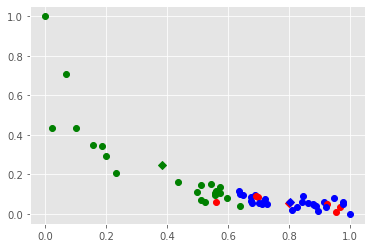

In [91]:
#!/usr/bin/env python
#-*- coding:utf-8 -*-
# author:wanglubao
# datetime:2019/9/22 14:31
# software: PyCharm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#加载数据
def loadDataSet():
    return np.array(kmeansmodel)#.tolist()

#欧氏距离计算
def distEclud(x,y):
    return np.sqrt(np.sum((x-y)**2))
# 为给定数据集构建一个包含K个随机质心的集合
def randCent(dataSet,k):
    # 获取样本数与特征值
    m,n=np.shape(np.array(kmeansmodel).tolist())#把数据集的行数和列数赋值给m,n
    # 初始化质心,创建(k,n)个以零填充的矩阵
    centroids = np.zeros((k,n))
    # 循环遍历特征值
    for i in range(k):
        index = int(np.random.uniform(0,m))
        # 计算每一列的质心,并将值赋给centroids
        centroids[i,:] = dataSet[index,:]
        # 返回质心
    return centroids


# k均值聚类
def KMeans(dataSet,k):
    m = np.shape(dataSet)[0]
    # 初始化一个矩阵来存储每个点的簇分配结果
    # clusterAssment包含两个列:一列记录簇索引值,第二列存储误差(误差是指当前点到簇质心的距离,后面会使用该误差来评价聚类的效果)
    clusterAssment = np.mat(np.zeros((m,2)))
    clusterChange = True

    # 创建质心,随机K个质心
    centroids = randCent(dataSet,k)
    # 初始化标志变量,用于判断迭代是否继续,如果True,则继续迭代
    while clusterChange:
        clusterChange = False

        #遍历所有样本（行数）
        for i in range(m):
            minDist = 100000.0
            minIndex = -1
            # 遍历所有数据找到距离每个点最近的质心,
            # 可以通过对每个点遍历所有质心并计算点到每个质心的距离来完成
            for j in range(k):
                # 计算数据点到质心的距离
                # 计算距离是使用distMeas参数给出的距离公式,默认距离函数是distEclud
                distance = distEclud(centroids[j,:],dataSet[i,:])
                # 如果距离比minDist(最小距离)还小,更新minDist(最小距离)和最小质心的index(索引)
                if distance < minDist:
                    minDist = distance
                    minIndex = j
            # 如果任一点的簇分配结果发生改变,则更新clusterChanged标志
            if clusterAssment[i,0] != minIndex:
                clusterChange = True
                # 更新簇分配结果为最小质心的index(索引),minDist(最小距离)
                clusterAssment[i,:] = minIndex,minDist
        # 遍历所有质心并更新它们的取值
        for j in range(k):
            # 通过数据过滤来获得给定簇的所有点
            pointsInCluster = dataSet[np.nonzero(clusterAssment[:,0].A == j)[0]]
            # 计算所有点的均值,axis=0表示沿矩阵的列方向进行均值计算
            centroids[j,:] = np.mean(pointsInCluster,axis=0)
    print("Congratulation,cluster complete!")
    print(clusterAssment)
    # 返回所有的类质心与点分配结果
    return centroids,clusterAssment

def showCluster(dataSet,k,centroids,clusterAssment):
    m,n = dataSet.shape
    #if n != 2:
       # print("数据不是二维的")
        #return 1

    mark = ['or','ob','og','ok','^r','+r','sr','dr','<r','pr']
    if k > len(mark):
        print("k值太大了")
        return 1
    #绘制所有样本
    for i in range(m):
        markIndex = int(clusterAssment[i,0])
        plt.plot(dataSet[i,0],dataSet[i,1],mark[markIndex])

    mark = ['Dr', 'Db', 'Dg', 'Dk', '^b', '+b', 'sb', 'db', '<b', 'pb']
    #绘制质心
    for i in range(k):
        plt.plot(centroids[i,0],centroids[i,1],mark[i])

    plt.show()
dataSet = loadDataSet()
k = 3
centroids,clusterAssment = KMeans(dataSet,k)
showCluster(dataSet,k,centroids,clusterAssment)






In [92]:
newmodel=model.copy()
newmodel["category"]=pd.DataFrame(clusterAssment.tolist())[0].copy()
def c(x):
    x=x.values
    return x
newmodel.groupby("category")["country"].apply(c).values

array([array(['Afghanistan', 'Algeria', 'Bolivia', 'Iran', 'Mexico', 'USA'],
             dtype=object)                                                  ,
       array(['Argentina', 'Bahrain', 'Brazil', 'Chile', 'Colombia', 'Germany',
              'India', 'Iraq', 'Ireland', 'Japan', 'Kazakhstan', 'Kuwait',
              'Moldova', 'Netherlands', 'Nigeria', 'Oman', 'Peru', 'Philippines',
              'Portugal', 'Russia', 'South Korea', 'Spain', 'Sweden', 'Turkey',
              'UK', 'Ukraine', 'United Arab Emirates'], dtype=object)            ,
       array(['Armenia', 'Austria', 'Azerbaijan', 'Belgium', 'China', 'Dominica',
              'Ecuador', 'Egypt', 'France', 'Ghana', 'Guatemala', 'Israel',
              'Italy', 'Pakistan', 'Panama', 'Poland', 'Qatar', 'Romania',
              'Serbia', 'Singapore', 'Switzerland'], dtype=object)               ],
      dtype=object)

In [95]:
# -*- coding: utf-8 -*-
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from matplotlib import pyplot as plt
 
def hierarchy_cluster(data, method='average', threshold=5.0):
    data = np.array(data)
 
    Z = linkage(data, method=method)
    cluster_assignments = fcluster(Z, threshold, criterion='distance')
    print( type(cluster_assignments))
    num_clusters = cluster_assignments.max()
    indices = get_cluster_indices(cluster_assignments)
 
    return num_clusters, indices
 
 
 
def get_cluster_indices(cluster_assignments):
    n = cluster_assignments.max()
    indices = []
    for cluster_number in range(1, n + 1):
        indices.append(np.where(cluster_assignments == cluster_number)[0])
    
    return indices
 
 
if __name__ == '__main__':
    
 
    arr = kmeansmodel
 
    arr = np.array(arr)
    r, c = arr.shape
    for i in range(r):
        for j in range(i, c):
            if arr[i][j] != arr[j][i]:
                arr[i][j] = arr[j][i]
    for i in range(r):
        for j in range(i, c):
            if arr[i][j] != arr[j][i]:
                print(arr[i][j], arr[j][i])
 
    num_clusters, indices = hierarchy_cluster(arr)
 
 
    print ("%d clusters" % num_clusters)
    for k, ind in enumerate(indices):
        print ("cluster", k + 1, "is", ind)
## 运行结果




<class 'numpy.ndarray'>
1 clusters
cluster 1 is [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53]


In [106]:
plt.figure(figsize=(10, 10), dpi=1000)
from scipy.cluster.hierarchy import linkage,dendrogram
data=np.array(newmodel)
z=linkage(data, method='ward')
dendrogram(z)
plt.show()